<a href="https://colab.research.google.com/github/shebogholo/pytorch/blob/master/Convolutional%20Neural%20Network%2001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [0]:
import os
import glob
import torch
import numpy as np
import torchvision
from PIL import Image
import torch.nn as nn
import os.path as path
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

## Hyperparameters

In [0]:
num_epochs = 30
batch_size = 32
log_interval = 1000
learning_rate = 0.001

## Custom Dataset

In [0]:
# Download MNIST png data
!wget -q https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true
!mv mnist_png.tar.gz?raw=true mnist_png.tar.gz
!tar -xzf mnist_png.tar.gz

In [0]:
# Define custom dataset class
class MNIST(Dataset):
  def __init__(self, root, transform=None):
    self.images = None
    self.labels = None
    self.root = root
    self.transform = transform
    self.filenames = []

    # read filenames
    for label in range(10):
      filenames = glob.glob(os.path.join(root, str(label), '*.png'))
      for filename in filenames:
        self.filenames.append((filename, label))


  def __getitem__(self, index):
    # load data from image list
    image, label = self.filenames[index]
    image = Image.open(image)

    if self.transform is not None:
      image = self.transform(image)
    # return image and label
    return image, label
  

  # total number of samples in the dataset
  def __len__(self):
    return len(self.filenames)

In [0]:
'''
Create instances of Custom dataset class for training and test data 
Convert all the images to Tensor (Transformation)
'''
trainset = MNIST(root='mnist_png/training', transform=transform.ToTensor())
testset  = MNIST(root='mnist_png/testing', transform=transform.ToTensor())

## DataLoader

In [0]:
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader  = DataLoader(testset,  batch_size=batch_size, shuffle=False, num_workers=1)

In [7]:
print('Train data: ',len(trainset))
print('Test  data: ',len(testset))

Train data:  60000
Test  data:  10000


## Visualize dataset

In [0]:
# function to show an image
def show_image(image):
  image = image.numpy()
  plt.imshow(np.transpose(image, (1, 2, 0)))

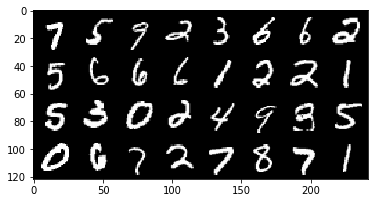

In [9]:
# get random training images
images, labels = iter(train_loader).next()
show_image(torchvision.utils.make_grid(images))

In [10]:
# check the available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Define a CNN

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        
        # Linear(in_features, out_features, bias=True)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
        # MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.max_pool = nn.MaxPool2d(2)
        # ReLU(inplace=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.max_pool(self.conv1(x)))
        x = self.relu(self.max_pool(self.conv2(x)))
        x = x.view(-1, 320)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
model = Network().to(device)

## Define Optimizer

In [0]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

## Define Loss function

In [0]:
criterion = nn.NLLLoss()

## Function to test a model

In [0]:
def test():
  model.eval()  # set evaluation mode
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for _, (data, target) in enumerate(test_loader):
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target).item() # sum up batch loss
      pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest loss: {:.4f}, accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

## Train CNN

In [16]:
iteration = 0
for epoch in range(num_epochs):
  for batch_idx, (data, target) in enumerate(train_loader):

    # bring data to the computing device, e.g. GPU
    data, target = data.to(device), target.to(device)

    # forward pass
    output = model(data)
    
    # compute loss: negative log-likelihood
    loss = criterion(output, target)
     
    # backward pass
    # clear the gradients of all tensors being optimized.
    optimizer.zero_grad()
    # accumulate (i.e. add) the gradients from this forward pass
    loss.backward()
    # performs a single optimization step (parameter update)
    optimizer.step()
    if iteration % log_interval == 0:
      print('Epoch: {} \tloss: {:.6f}'.format(epoch+1, loss.item()))
    iteration += 1
  test()

Epoch: 1 	loss: 2.305253
Epoch: 1 	loss: 0.213890

Test loss: 0.0075, accuracy: 9253/10000 (93%)

Epoch: 2 	loss: 0.141696
Epoch: 2 	loss: 0.048884

Test loss: 0.0038, accuracy: 9628/10000 (96%)

Epoch: 3 	loss: 0.039505
Epoch: 3 	loss: 0.168364

Test loss: 0.0029, accuracy: 9699/10000 (97%)

Epoch: 4 	loss: 0.093849
Epoch: 4 	loss: 0.130581

Test loss: 0.0025, accuracy: 9754/10000 (98%)

Epoch: 5 	loss: 0.026748
Epoch: 5 	loss: 0.020112

Test loss: 0.0019, accuracy: 9802/10000 (98%)

Epoch: 6 	loss: 0.051723
Epoch: 6 	loss: 0.070295

Test loss: 0.0017, accuracy: 9830/10000 (98%)

Epoch: 7 	loss: 0.071714
Epoch: 7 	loss: 0.029261

Test loss: 0.0017, accuracy: 9836/10000 (98%)

Epoch: 8 	loss: 0.013148

Test loss: 0.0016, accuracy: 9836/10000 (98%)

Epoch: 9 	loss: 0.053063
Epoch: 9 	loss: 0.062835

Test loss: 0.0014, accuracy: 9866/10000 (99%)

Epoch: 10 	loss: 0.003347
Epoch: 10 	loss: 0.010234

Test loss: 0.0014, accuracy: 9864/10000 (99%)

Epoch: 11 	loss: 0.041110
Epoch: 11 	loss: 

## Save model

In [0]:
def save_checkpoint(checkpoint_path, model, optimizer):
    '''
      state_dict: a Python dictionary object that:
       - for a model, maps each layer to its parameter tensor;
       - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    '''
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('Model saved to {}'.format(checkpoint_path))
    
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('Model loaded from {}'.format(checkpoint_path))

## Fine-tune a model